In [1]:
%run /work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/duplications/

/work/clusterEvo/new_tests/eggNOG/duplications


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
few_duplications = pd.read_parquet('few_duplication_genes.parquet')
few_duplications.head()

,group_id,num_proteins,num_taxa,members,taxa
1217,arCOG00018,195,166,"1006006.Mcup_1244,1033806.HTIA_0702,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1219,arCOG00020,174,158,"1006006.Mcup_1524,1006006.Mcup_1889,1041930.Mt...","[1006006, 1006006, 1041930, 1042877, 1054217, ..."
1227,arCOG00028,108,103,"1041930.Mtc_2182,1070774.J07HN4v3_02653,109498...","[1041930, 1070774, 1094980, 1114856, 1114856, ..."
1228,arCOG00029,170,167,"1006006.Mcup_0319,1033806.HTIA_1327,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1230,arCOG00031,117,100,"1006006.Mcup_0023,1033806.HTIA_1326,1042877.GQ...","[1006006, 1033806, 1042877, 1056495, 1056495, ..."


In [5]:
eggNOG_trees = pd.read_csv('../2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=few_duplications.group_id)

In [6]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

In [10]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    return(assess_coevolution(m1, m2, gene_sep='.')[1])

matrix1 = dist_matrices[18].copy()
matrix2 = dist_matrices[19].copy()
run_coevol((matrix1, matrix2))

0.8713248922984702

In [41]:
if not os.path.isfile('odr_regression_Rsquared.parquet'):
    pool   = multiprocessing.Pool(processes=10)
    odr_r2 = pool.map(run_coevol, itertools.combinations(dist_matrices, 2))

    group_pairs = []
    for pair in itertools.combinations(group_ids, 2):
        group_pairs.append(pair)

    group_pairs = np.array(group_pairs)
    
    odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                          data   =zip(group_pairs[:, 0],
                                      group_pairs[:, 1],
                                      odr_r2))
    odr_df.to_parquet('odr_regression_Rsquared.parquet')
else:
    odr_df = pd.read_parquet('odr_regression_Rsquared.parquet')

In [42]:
odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

odr_df.head()

,group1,group2,Rsquared
group_pair,,,
"(arCOG00020, arCOG00018)",arCOG00018,arCOG00020,0.826628
"(arCOG00018, arCOG00028)",arCOG00018,arCOG00028,0.931708
"(arCOG00018, arCOG00029)",arCOG00018,arCOG00029,0.757072
"(arCOG00031, arCOG00018)",arCOG00018,arCOG00031,0.894787
"(arCOG00034, arCOG00018)",arCOG00018,arCOG00034,0.910943


In [18]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

if not os.path.isfile('braycurtis_indices.parquet'):
    pool               = multiprocessing.Pool(processes=10)
    braycurtis_indices = pool.map(get_braycurtis, 
                                  itertools.combinations(few_duplications.iterrows(), 2))

    braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                                 data   =braycurtis_indices)
    braycurtis_df.to_parquet('braycurtis_indices.parquet')
else:
    braycurtis_df = pd.read_parquet('braycurtis_indices.parquet')

In [30]:
braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)
braycurtis_df.head()

,group1,group2,braycurtis
group_pair,,,
"(arCOG00020, arCOG00018)",arCOG00018,arCOG00020,0.850949
"(arCOG00018, arCOG00028)",arCOG00018,arCOG00028,0.679868
"(arCOG00018, arCOG00029)",arCOG00018,arCOG00029,0.915068
"(arCOG00031, arCOG00018)",arCOG00018,arCOG00031,0.634615
"(arCOG00034, arCOG00018)",arCOG00018,arCOG00034,0.859551


In [43]:
odr_df = odr_df.join(braycurtis_df.braycurtis)
odr_df['coevol_metric'] = odr_df.Rsquared * (odr_df.braycurtis**2)

odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
group_pair,,,,,
"(arCOG00020, arCOG00018)",arCOG00018,arCOG00020,0.826628,0.850949,0.598573
"(arCOG00018, arCOG00028)",arCOG00018,arCOG00028,0.931708,0.679868,0.430654
"(arCOG00018, arCOG00029)",arCOG00018,arCOG00029,0.757072,0.915068,0.633934
"(arCOG00031, arCOG00018)",arCOG00018,arCOG00031,0.894787,0.634615,0.360364
"(arCOG00034, arCOG00018)",arCOG00018,arCOG00034,0.910943,0.859551,0.673029


In [46]:
data_columns = ['Rsquared', 'coevol_metric', 'braycurtis']

In [39]:
string = pd.read_parquet('few_duplications-string.parquet')

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

# strongly_related = string.query('combined_score >= 900')
# weakly_related   = string.query('combined_score <= 200')

neighors     = string.query('neighborhood >= 700')
not_neighors = string.query('neighborhood <= 200')

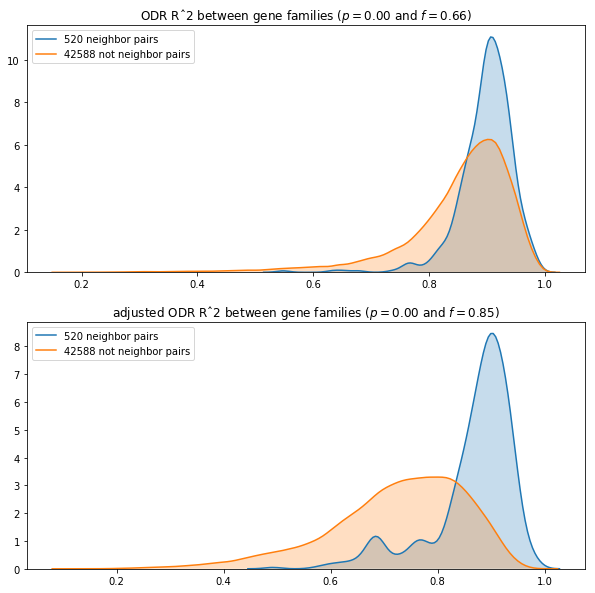

In [54]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor pairs',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

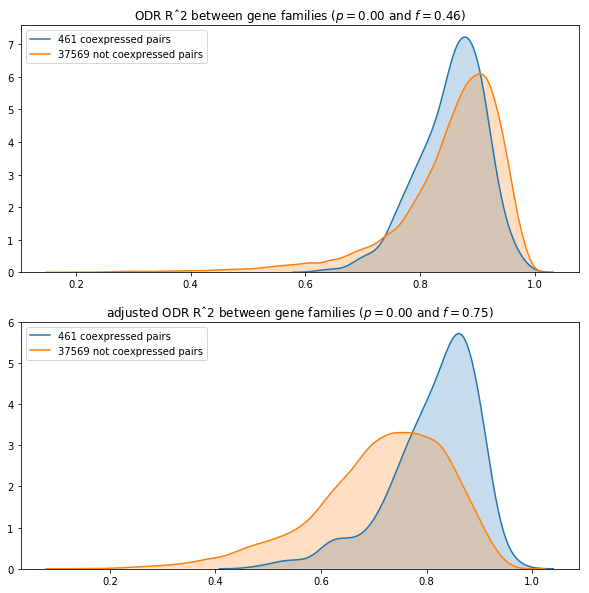

In [55]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    coexpressed     = string.query('coexpression >= 700')
    not_coexpressed = string.query('coexpression <= 200')

    coexpressed_odr     = odr_df.query('group_pair in @coexpressed.group_pair'    )[column].values
    not_coexpressed_odr = odr_df.query('group_pair in @not_coexpressed.group_pair')[column].values

    hypothesis = mannwhitneyu(not_coexpressed_odr,
                              coexpressed_odr)
    effect_size = cles(not_coexpressed_odr, coexpressed_odr)

    sns.kdeplot(coexpressed_odr, shade=True,     label=f'{len(coexpressed_odr)} coexpressed pairs', ax=ax)
    sns.kdeplot(not_coexpressed_odr, shade=True, label=f'{len(not_coexpressed_odr)} not coexpressed pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');